Iota Calculation, Fourier Surface Extraction, and Perturbations (Wendelstein 7-X)
=================================================================================

This example shows how to calculate the rotational transform for Wendelstein 7-X. 

In [1]:
import fusionsc as fsc
from fusionsc.devices import w7x
import numpy as np
import matplotlib.pyplot as plt

First, we need to perform some setup to make sure W7-X data are available.

Note: The W7-X geometry is currently protected by the W7-X data access agreement. Therefore, the file referenced below is available to W7-X team members (including external collaborators who signed this agreement) upon request.

In [2]:
fsc.resolve.importOfflineData('../../w7x-op21.fsc')

Now we need to setup the geometry and magnetic field configuration. To speed up the magnetic field calculation, we use a slightly coarser grid.

In [3]:
field = w7x.standard()

grid = w7x.defaultGrid()
grid.nR = 32
grid.nZ = 32
grid.nPhi = 32

field = field.compute(grid)
await field

Finally, we need to decide in which phi planes we want to evaluate our iota and start our surfaces from.

In [4]:
xStart = np.linspace(5.65, 6.3, 30)
yStart = 0 * xStart
zStart = 0 * xStart

Now it's time to run our calculation.

In [5]:
iotas = fsc.flt.calculateIota(
    field, [xStart, yStart, zStart],
    200, # Turn count
    unwrapEvery = 10, distanceLimit = 1e4, 
    targetError = 1e-3, minStepSize = 1e-3
)

The iota profile is returned in a shape matching the start point shape, and can be easily plotted.

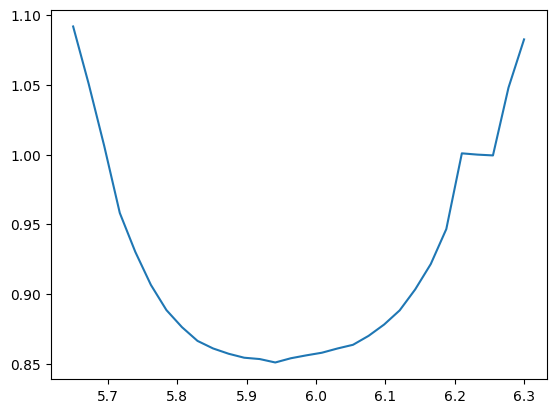

In [6]:
plt.plot(xStart, iotas)

Additionally, the field line tracer can also extract the Fourier decomposition of the magnetic surfaces from the field line. 

In [7]:
modes = fsc.flt.calculateFourierModes(
    field, [xStart, yStart, zStart],
    200, # Turn count
    nMax = 5, mMax = 5, toroidalSymmetry = 5,
    unwrapEvery = 10, recordEvery = 10,
    targetError = 1e-3, distanceLimit = 1e5,
    stellaratorSymmetric = True, aliasThreshold = 0.05
)

The modes are returned with a dict containing rotational transform and the Fourier expansion of the modes, as well as an encoding of the result as a FourierSurfaces object that can also be used in VMEC inputs.

In [8]:
modes.keys()

dict_keys(['surfaces', 'iota', 'theta', 'rCos', 'zSin', 'mPol', 'nTor'])

Of particular interest are two components: The first one is the 'iota' array, which returns the rotational transforms.

In [9]:
modes["iota"]

array([1.09447588, 1.05247213, 1.01666022, 0.9602022 , 0.93233484,
       0.90942027, 0.8912811 , 0.87845593, 0.86940964, 0.86348805,
       0.85972598, 0.85709404, 0.85602258, 0.85346657, 0.85460789,
       0.85649626, 0.85789374, 0.8605038 , 0.86435725, 0.87004013,
       0.87795422, 0.88875366, 0.90336695, 0.92213986, 0.94644839,
       1.00000732, 0.9999624 , 0.9999996 , 1.0477615 , 1.08245534])

Secondarily relevant is the 'surfaces' element, which contains the magnetic surfaces. This is an instance of the class fusionsc.magnetics.SurfaceArray, which can be sliced, added, and multiplied similar to a regular NumPy array.

In [10]:
surfaces = modes["surfaces"]

print(type(surfaces))
print("First:\n", surfaces[0])
print("Last:\n", surfaces[-1])
print("Average:\n", (surfaces[0] + surfaces[-1]) / 2)

<class 'fusionsc.magnetics.SurfaceArray'>
First:
 rCos:
  shape: [11, 6]
  data: [5.433495606933926, 0.62934012052192601, 0.10906450150603933, 0.010237712174448462, 0.005726106093615721, 0.0020260640936492023, 0.17186549616022356, -0.28715687970167736, 0.064084425034716633, 0.01653462092100411, 0.0078069638426925374, -0.0049701898886877448, -0.0058316631723702699, 0.0068069033873470915, 0.1005677946361741, -0.016063533954723132, -0.012395413862362998, -0.007146420680677115, 0.00030666678122215298, 0.0077005403618819199, -0.0081588134483962082, -0.022000636261533032, 0.015046667679951973, 0.0023846581209990706, -0.00072191292822869086, 0.0019304264759789952, -0.0017633663232099481, -0.00034184576192679533, -0.001703974527691705, -0.0088272961346056323, 0.00064857861481161625, 0.0016970085094088793, -0.00058966092860283763, -0.00084225501363475238, 0.00075506790861227591, 0.0010024837395620518, 0, -0.00057068833425310639, -0.00012046447417307941, 0.0027348598114072436, -0.002773700357469

In [11]:
modes["theta"]

array([ 2.72059731e+00,  3.03995217e+00,  2.05986030e+00,  3.00755935e+00,
        2.99723189e+00,  3.03481665e+00,  3.01374355e+00,  3.00912547e+00,
        3.04094965e+00,  3.04569230e+00,  3.04157960e+00,  3.02792888e+00,
        3.04225458e+00,  3.01909746e+00, -8.90831502e-03,  5.91743289e-03,
       -2.00336966e-02, -2.62247837e-02, -2.47317720e-03,  1.54213401e-02,
       -1.05742398e-02, -2.00807365e-02,  1.13339854e-02,  4.66026507e-03,
       -2.51622200e-02,  8.37882818e-02, -1.89143929e-02,  2.99912040e-01,
       -9.47747656e-02, -4.18862949e-03])

To plot the modes, we need to multiply the Fourier coefficients with the appropriate angles.

(3, 30, 3, 100)


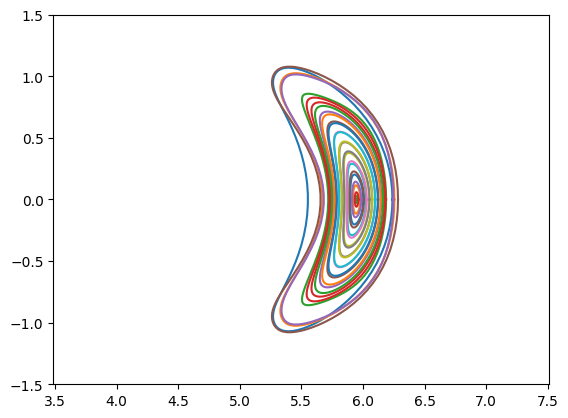

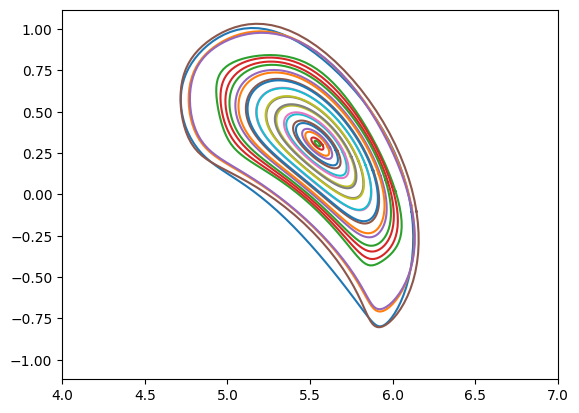

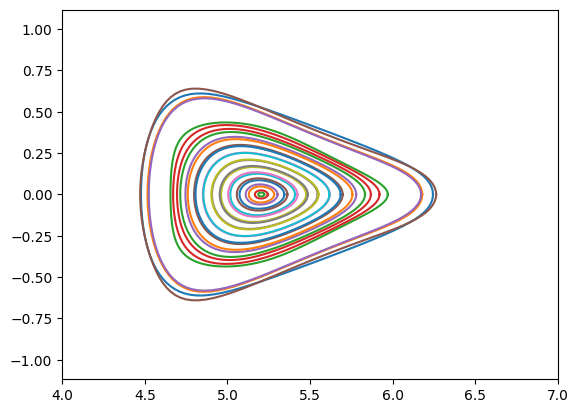

In [12]:
iSurf = 0
thetas = np.linspace(0, 2 * np.pi, 100)
phis = np.linspace(0, 2 * np.pi / 10, 3)

data = surfaces.evaluate(phis, thetas) # Surfaces -5, -4, -3 are rational and failed to reconstruct

print(data['points'].shape)

for iPhi in range(len(phis)):
    plt.figure()
    for iSurf in range(0, surfaces.shape[0]):
        if abs(modes['iota'][iSurf] - 1) < 0.02:
            continue
            
        dp = 1
        x, y, z = data['points'][:,iSurf,iPhi,::dp]
        dx, dy, dz = data['thetaDerivatives'][:,iSurf,iPhi,::dp]
        
        r = np.sqrt(x**2 + y**2)
        
        dr = (dx * x + dy * y) / r
        
        
        plt.plot(r, z)
        #plt.quiver(r, z, dr, dz)
    plt.axis('equal')
    plt.xlim(4, 7)
    plt.ylim(-1.5, 1.5)
plt.show()

The obtained surfaces can also be used to calculate a mode decomposition of the magnetic field

C:\Users\Knieps\Documents\repos\fsc\src\python\fusionsc\_api_markers.py:15: UserWarning: The function fusionsc.magnetics.MagneticConfig.calculateRadialModes is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.
  warnings.warn(f"The function {f.__module__}.{f.__qualname__} is part of the unstable API. It might change or get removed in the near future. While unlikely, it might also not be compatible across client/server versions.")


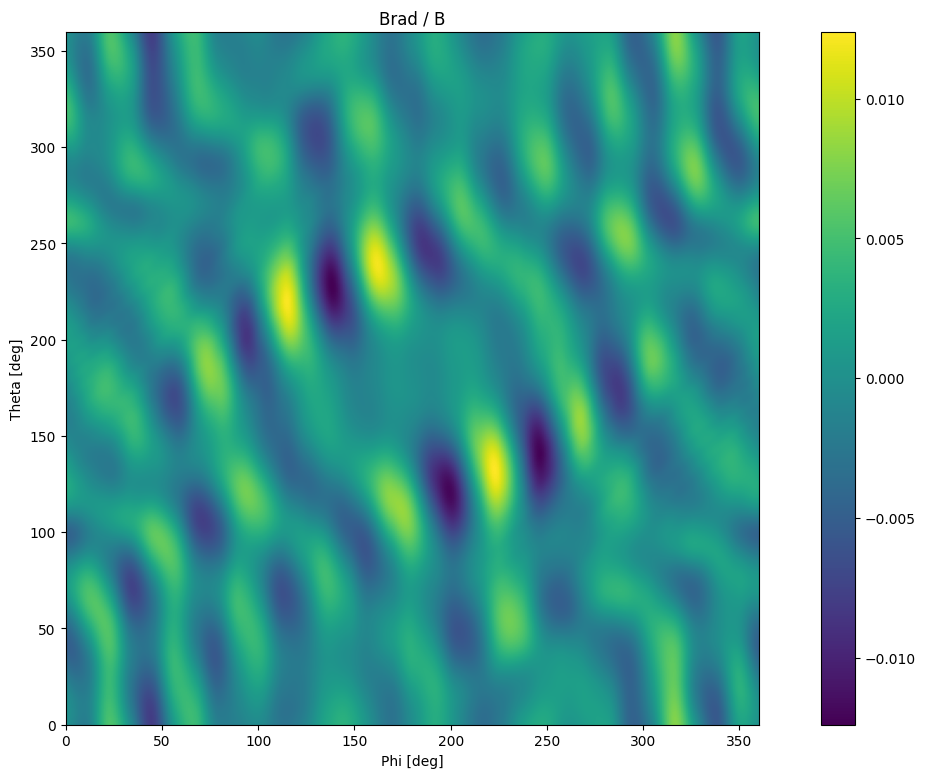

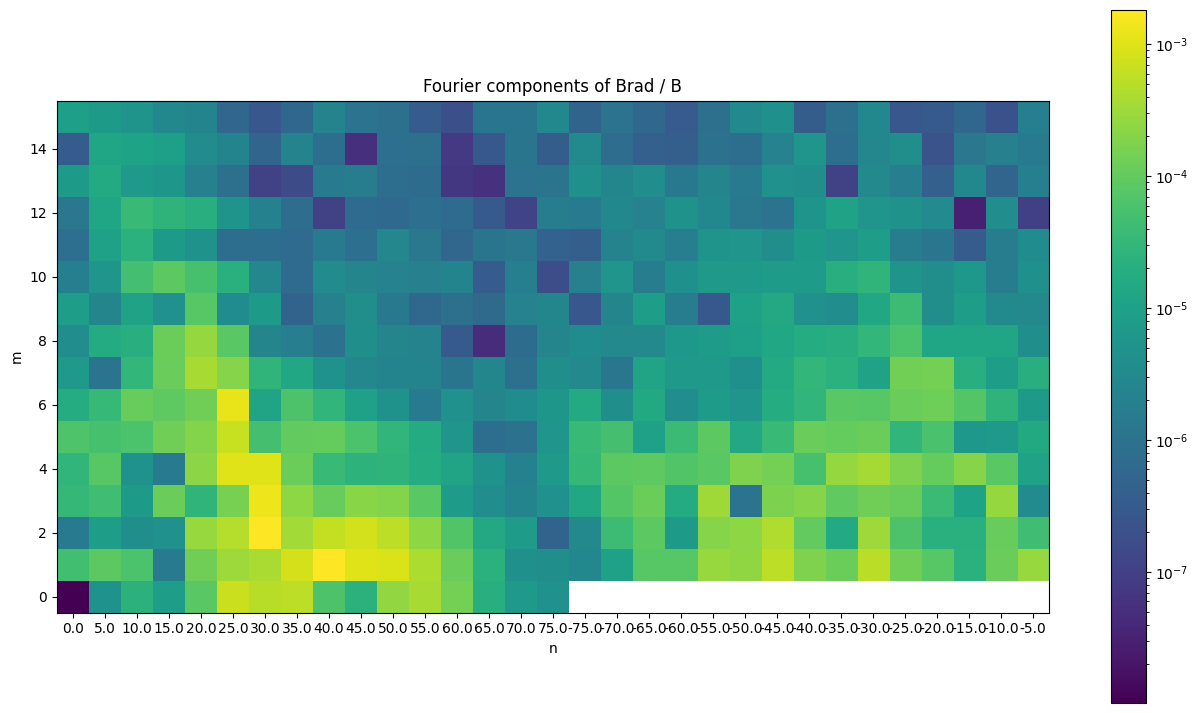

(400, 400)
n = 0, m = 0, val = 1.02e-08
n = 5, m = 0, val = 5.13e-06
n = 10, m = 0, val = 2.46e-05
n = 0, m = 1, val = 4.73e-05
n = 5, m = 1, val = 8.47e-05
n = 10, m = 1, val = 5.85e-05
n = 0, m = 2, val = 1.51e-06
n = 5, m = 2, val = 8.72e-06
n = 10, m = 2, val = 4.20e-06
n = 0, m = 3, val = 3.17e-05
n = 5, m = 3, val = 4.46e-05
n = 10, m = 3, val = 7.38e-06
n = 0, m = 4, val = 2.95e-05
n = 5, m = 4, val = 7.71e-05
n = 10, m = 4, val = 4.86e-06
n = 0, m = 5, val = 6.37e-05
n = 5, m = 5, val = 5.40e-05
n = 10, m = 5, val = 6.06e-05


In [13]:
surf = surfaces[6]
#np.asarray(surf.data.rCos)[0,0] += 0.03

fieldModes = field.calculateRadialModes(surf, field, nSym = 5, mMax = 15, nMax = 15, nTheta = 400, nPhi = 400)
cc = fieldModes["cosCoeffs"]
sc = fieldModes["sinCoeffs"]

m = fieldModes["mPol"]
n = fieldModes["nTor"]

phi = fieldModes["phi"]
theta = fieldModes["theta"]

tot = np.sqrt(cc**2 + sc**2)

plt.figure(figsize=(16,9))
plt.imshow(fieldModes["radialValues"].T, origin='lower', extent = [0, 360, 0, 360])
plt.colorbar()
plt.title("Brad / B")
plt.xlabel('Phi [deg]')
plt.ylabel('Theta [deg]')

plt.figure(figsize=(16,9))
plt.imshow(tot.T, origin = "lower", norm = "log")
#plt.xlabel(f"n[0, {n[1]:.0f} ... {max(n):.0f}, {min(n):.0f}, ..., {n[-1]:.0f}]")
plt.xlabel("n")
plt.ylabel("m")
plt.xticks(range(len(n)), n)
plt.title("Fourier components of Brad / B")
plt.colorbar()
plt.show()

print(fieldModes["radialValues"].shape)
for i_m, mVal in enumerate(m):
    for i_n, nVal in enumerate(n):
        if mVal > 5: continue
        if nVal < 0: continue
        if nVal > 10: continue
        print(f"n = {nVal:.0f}, m = {mVal:.0f}, val = {tot[i_n][i_m]:.2e}")


In [14]:
#asPv = surfaces[0].asGeometry().asPyvista()
#asPv.plot()

In [16]:
surfaces.save("surf.fsc")

In [1]:
import fusionsc as fsc

In [2]:
surfaces = fsc.magnetics.SurfaceArray.load("surf.fsc")

In [9]:
geo = surfaces[0].asGeometry(10, 10)